# Library import

In [1]:
import bw2io as bi
import bw2data as bd
import bw2calc as bc
#from bw_temporalis import easy_timedelta_distribution, TemporalisLCA
import bw_temporalis as bwt
import bw_processing as bwp
from utils import *
import warnings

# Set project and databases

In [2]:
# try:
#     bd.projects.delete_project("tictacthree", True)
# except ValueError:
#     pass

In [3]:
#project_backup_directory = '/Users/jeromea/Downloads/brightway2-project-tictacthree-backup.12-October-2023-06-16PM.tar.gz'
#bi.backup.restore_project_directory(project_backup_directory)

In [4]:
bd.projects.set_current('tictacthree')

In [5]:
bd.databases

Databases dictionary with 8 object(s):
	biosphere3
	ecoinvent-3.9-cutoff
	ecoinvent_cutoff_3.9_remind_SSP2-PkBudg1150_2020
	ecoinvent_cutoff_3.9_remind_SSP2-PkBudg1150_2030
	ecoinvent_cutoff_3.9_remind_SSP2-PkBudg1150_2040
	ecoinvent_cutoff_3.9_remind_SSP2-PkBudg1150_2050
	wind-example
	wind_db

In [6]:
bd.projects.twofive

True

In [7]:
ei = bd.Database('ecoinvent-3.9-cutoff')

## Foreground database

### Temporal distributions

#### Temporal distribution for wind electricity (onshore) in `Europe`, corresponding to `remind SSP2 - 1150` IAM scenario

In [8]:
a = np.array([0.79, 1.57, 3.6, 6.03, 8.73, 10.66, 11.27, 11.31])
a = a/np.sum(a) # normalizing the trend in Exajoules to get an actual TD

Absolute temproal distribution:

In [9]:
d = np.array([str(2010+k*10)+"-01-01" for k in range(8)])
d = np.array(d,dtype=np.datetime64)

In [10]:
inc_wind_turbine_energy_absolute = bwt.TemporalDistribution(
    date=d,
    amount=a
)
#inc_wind_turbine_energy_absolute.graph()

Relative temporal distribution:

In [11]:
delta = np.array([np.timedelta64(10*(k+1), 'Y') for k in range(8)])

In [12]:
inc_wind_turbine_energy_relative = bwt.TemporalDistribution(
    date=delta,
    amount=a
)
#inc_wind_turbine_energy_relative.graph()

### Selection of useful activities

In [13]:
wind_construction = ei.get(name="wind turbine construction, 2MW, onshore", location="GLO")
wind_construction

'wind turbine construction, 2MW, onshore' (unit, GLO, None)

In [14]:
market_electricity = ei.get(name="market group for electricity, medium voltage", location="RER")
market_electricity

'market group for electricity, medium voltage' (kilowatt hour, RER, None)

In a foreground model with a loop (electricity produced by the wind turbine is used to produce the wind turbine), the electricity for the wind turbine production needs to be removed from the ecoinvent process:

In [18]:
del bd.databases["wind_db"]
bd.Database("wind_db").register()
wind_construction.copy(database="wind_db")

'wind turbine construction, 2MW, onshore' (unit, GLO, None)

Remove the electricity input during construction as it will be added in the foreground database:

In [19]:
wt_construction = bd.Database("wind_db").get(name="wind turbine construction, 2MW, onshore", location="GLO")
ex = [e for e in wt_construction.exchanges() if "electricity" in e.input["name"]][0]

# change amount
ex["amount"] = 0
ex.save()

### Foreground system without loop

In [20]:
def wind_example_writting(wt_lifetime=20, wt_output=2000, wt_capacity=0.2):

    generated_electricity_over_lifetime = wt_capacity*(wt_output*365*24)*wt_lifetime  # Amount of electricity generated by a wind turbine over its lifetime in kWh, 20% of capacity factor

    bd.Database('wind-example').write({
        ('wind-example', 'wind-electricity-production'): {
            'name': 'Electricity production, wind',
            'unit': 'kilowatt hour',
            'exchanges': [
                {
                    'input': ('wind-example', 'operation-wind-turbine'),
                    'amount': 1/generated_electricity_over_lifetime,
                    'type': 'technosphere',
                    'temporal_distribution': inc_wind_turbine_energy_relative, #we would prefer to use the absolute TD, but for some reason the graph reversal isn't working with it...
                },
            ]
        },
            ('wind-example', 'operation-wind-turbine'): {
            'name': "Wind turbine, operated",
            'unit': 'unit',
            'exchanges': [
                {
                    'input': wind_construction,
                    'amount': 1,
                    'type': 'technosphere',
                    'temporal_distribution': bwt.easy_timedelta_distribution(
                        start=-4,
                        end=0,
                        resolution="Y",  # M for months, Y for years, etc.
                        steps=5,
                        kind = 'triangular',
                        param = -1
                    ),
                },
                {
                    'input': ('wind-example', 'eol-wind-turbine'),
                    'amount': 1,
                    'type': 'technosphere',
                    'temporal_distribution': bwt.easy_timedelta_distribution(
                        start=10,
                        end=20,
                        resolution="Y",  # M for months, Y for years, etc.
                        steps=11,
                        kind = 'triangular',
                        param = 15
                    )
                },
            ]
        },
        ('wind-example', 'eol-wind-turbine'): {
            'name': "End-of-life, wind turbine",
            'unit': 'unit',
            'exchanges': [
                {
                    'input': market_electricity,
                    'amount': 0.25*1.443e5, #Quantity retrieved on ecoinvent
                    'type': 'technosphere',
                },
                {
                    'input': wt_construction,
                    'amount': 0.25, #Dummy process and quantity to add some impact
                    'type': 'technosphere',
                },
            ]
        },
    })

In [21]:
if "wind-example" in bd.databases:
    del bd.databases['wind-example']

In [22]:
wind_example_writting()

Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<?, ?it/s]

Vacuuming database 


### Foreground system with a loop

This is not ready as there is no temporal distribution for the share of wind electricity in the mix.

In [21]:
if "wind-example-loop" in bd.databases:
    del bd.databases['wind-example-loop']

In [25]:
def wind_example_loop_writting(wt_lifetime=20, wt_output=2000, wt_capacity=0.2, share_of_wind_in_electricity_mix=0.7):

    generated_electricity_over_lifetime = wt_capacity*(wt_output*365*24)*wt_lifetime  # Amount of electricity generated by a wind turbine over its lifetime in kWh, 20% of capacity factor

    bd.Database('wind-example-loop').write({
        ('wind-example-loop', 'electricity-mix+wind'): {
            'name': 'Electricity mix',
            'unit': 'kilowatt hour',
            'exchanges': [
                {
                    'input': ('wind-example-loop', 'electricity-production-wind'),
                    'amount': share_of_wind_in_electricity_mix,
                    'type': 'technosphere',
                    #'temporal_distribution' : TD_constant_increase_wind_share,
                },
                {
                    'input': (market_electricity),
                    'amount': 1-share_of_wind_in_electricity_mix,
                    'type': 'technosphere',
                },
            ]
        },
        ('wind-example-loop', 'electricity-production-wind'): {
            'name': 'Electricity production, wind',
            'unit': 'kilowatt hour',
            'exchanges': [
                {
                    'input': ('wind-example-loop', 'electricity-production-wind'),
                    'amount': 1,
                    'type': 'production',
                },
                {
                    'input': ('wind-example-loop', 'operational-wind-turbine'),
                    'amount': 1/generated_electricity_over_lifetime,
                    'type': 'technosphere',
                    'temporal_distribution' : inc_wind_turbine_energy_relative, #we would prefer to use the absolute TD, but for some reason the graph reversal isn't working with it...
                },
            ]
        },
            ('wind-example-loop', 'operational-wind-turbine'): {
            'name': "End-of-life, wind turbine",
            'unit': 'unit',
            'exchanges': [
                {
                    'input': ('wind-example-loop', 'wind-turbine-construction'),
                    'amount': 1,
                    'type': 'technosphere',
                    'temporal_distribution': bwt.easy_timedelta_distribution(
                        start=-4,
                        end=0,
                        resolution="Y",  # M for months, Y for years, etc.
                        steps=5,
                        kind = 'triangular',
                        param = -1
                    ),
                },
                {
                    'input': ('wind-example-loop', 'eol-wind'),
                    'amount': 1,
                    'type': 'technosphere',
                    'temporal_distribution': bwt.easy_timedelta_distribution(
                        start=10,
                        end=20,
                        resolution="Y",  # M for months, Y for years, etc.
                        steps=11,
                        kind = 'triangular',
                        param = 15
                    )
                },
            ]
        },
        ('wind-example-loop', 'wind-turbine-construction'): {
            'name': 'Wind turbine construction',
            'unit': 'unit',
            'exchanges': [
                {
                    'input': ('wind-example-loop', 'wind-turbine-construction'),
                    'amount': 1,
                    'type': 'production',
                },
                {
                    'input': ('wind-example-loop', 'electricity-mix+wind'),
                    'amount': 0.75*1.443e5,
                    'type': 'technosphere',
                },
                {
                    'input': wt_construction,
                    'amount': 0.75,
                    'type': 'technosphere',
                },
            ]
        },
        ('wind-example-loop', 'eol-wind'): {
            'name': "End-of-life, wind turbine",
            'unit': 'unit',
            'exchanges': [
                {
                    'input': ('wind-example-loop', 'eol-wind'),
                    'amount': 1,
                    'type': 'production',
                },
                {
                    'input': ('wind-example-loop', 'electricity-mix+wind'),
                    'amount': 0.25*1.443e5,
                    'type': 'technosphere',
                },
                {
                    'input': wt_construction,
                    'amount': 0.25,
                    'type': 'technosphere',
                },
            ]
        },
    })

# LCA method

In [23]:
cc_method = [m for m in bd.methods if 'IPCC 2013' in str(m) and 'GWP100' in str(m) and 'no LT' in str(m)][0]
cc_method

('IPCC 2013 no LT',
 'climate change no LT',
 'global warming potential (GWP100) no LT')

# Static LCA

In [24]:
fu_now = {('wind-example', 'wind-electricity-production'): 1}

In [25]:
lca_now_static = bc.LCA(fu_now, cc_method)
lca_now_static.lci()
lca_now_static.lcia()

In [26]:
lca_now_static.score

0.02226615330286562

# Dynamic LCA (temporalis)

In [28]:
tlca_now = bwt.TemporalisLCA(lca_now_static, starting_datetime=np.datetime64(40, 'Y'))

Starting graph traversal


KeyboardInterrupt: 

In [13]:
tl_now = tlca_now.build_timeline()

In [14]:
tl_df_now = tl_now.build_dataframe()
tl_df_now = tl_now.add_metadata_to_dataframe(database_labels=["wind-example"], fields=['name', 'unit'])

In [15]:
tl_df_now

,date,amount,flow,activity
0,2018-10-12 03:14:08,0.000167,113,118
1,2018-10-12 03:14:08,0.000117,113,116
2,2018-10-12 03:14:08,0.000167,113,119
3,2019-10-12 09:03:20,0.000167,113,118
4,2019-10-12 09:03:20,0.000117,113,116
5,2019-10-12 09:03:20,0.000167,113,119
6,2020-10-11 14:52:32,0.000117,113,116
7,2020-10-11 14:52:32,0.000167,113,119
8,2020-10-11 14:52:32,0.000167,113,118
9,2021-10-11 20:41:44,0.000167,113,119


<Axes: xlabel='date', ylabel='amount'>

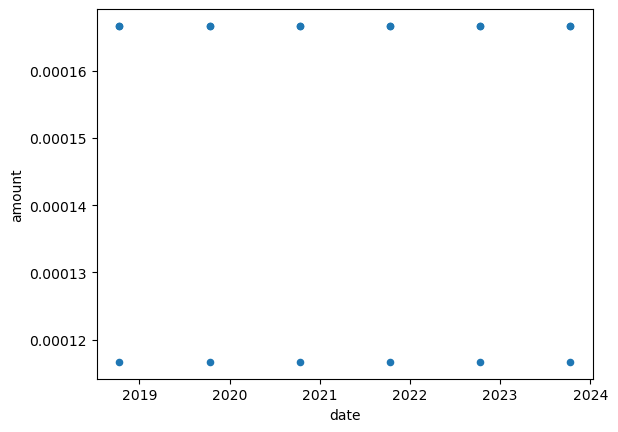

In [16]:
tl.df.plot(x="date", y="amount", kind="scatter")

In [17]:
tl_dt = tl.add_metadata_to_dataframe(database_labels=["wind-example-2020"], fields=['name', 'unit', 'location', 'categories'])

In [18]:
tl_dt

,date,amount,flow,activity,activity_name,activity_unit,flow_name,flow_unit
0,2018-10-12 03:14:08,0.000167,113,118,Wind turbine construction,unit,carbon dioxide,kilogram
1,2018-10-12 03:14:08,0.000117,113,116,"Electricity production, coal",kilowatt hour,carbon dioxide,kilogram
2,2018-10-12 03:14:08,0.000167,113,119,"End-of-life, wind turbine",unit,carbon dioxide,kilogram
3,2019-10-12 09:03:20,0.000167,113,118,Wind turbine construction,unit,carbon dioxide,kilogram
4,2019-10-12 09:03:20,0.000117,113,116,"Electricity production, coal",kilowatt hour,carbon dioxide,kilogram
5,2019-10-12 09:03:20,0.000167,113,119,"End-of-life, wind turbine",unit,carbon dioxide,kilogram
6,2020-10-11 14:52:32,0.000117,113,116,"Electricity production, coal",kilowatt hour,carbon dioxide,kilogram
7,2020-10-11 14:52:32,0.000167,113,119,"End-of-life, wind turbine",unit,carbon dioxide,kilogram
8,2020-10-11 14:52:32,0.000167,113,118,Wind turbine construction,unit,carbon dioxide,kilogram
9,2021-10-11 20:41:44,0.000167,113,119,"End-of-life, wind turbine",unit,carbon dioxide,kilogram


In [107]:
tl = tlca.build_timeline(node_timeline=True)
tl.build_dataframe()
tl_df = tl.add_metadata_to_dataframe(database_labels=["wind-example-2020"], fields=['name', 'unit'])

C:\Users\jeromea\AppData\Local\Continuum\anaconda3\envs\tictac\lib\site-packages\bw_temporalis\lca.py:129: UserWarning: This functionality is experimental, and will change.
You have been warned.
  warnings.warn(


# Interpolation

## First: nearest year

In [20]:
def add_column_nearest_year_on_timeline(tl_df, dates_list):
    """
    Add a column to a timeline with the year of the database, within the list of year of available databases, 
    that is the nearest to the date in the timeline.

    :param tl_df: Timeline as a dataframe.
    :param dates_list: List of years of the available databases.
    
    :return: Timeline as a dataframe with a column 'nearest_year' (int64) added.
    -------------------
    Example:
    >>> dates_list = [
        datetime.strptime("2020", "%Y"),
        datetime.strptime("2022", "%Y"),
        datetime.strptime("2025", "%Y"),
    ]
    >>> add_column_nearest_year_on_timeline(tl_df, dates_list)
    """
    if "date" not in list(tl_df.columns):
        raise ValueError("The timeline does not contain dates.")
    tl_df['nearest_year'] = tl_df['date'].apply(lambda x: find_closest_date(x, dates_list).year)
    return tl_df

In [21]:
dates_list = [
        datetime.strptime("2020", "%Y"),
        datetime.strptime("2035", "%Y"),
        datetime.strptime("2050", "%Y"),
    ]

In [22]:
add_column_nearest_year_on_timeline(tl_df, dates_list)

,date,amount,flow,activity,activity_name,activity_unit,flow_name,flow_unit,nearest_year
0,2018-10-12 03:14:08,0.000167,-1,118,Wind turbine construction,unit,NaN,NaN,2020
1,2018-10-12 03:14:08,0.000167,-1,115,Electricity mix,kilowatt hour,NaN,NaN,2020
2,2018-10-12 03:14:08,0.000117,-1,116,"Electricity production, coal",kilowatt hour,NaN,NaN,2020
3,2018-10-12 03:14:08,0.000167,-1,119,"End-of-life, wind turbine",unit,NaN,NaN,2020
4,2019-10-12 09:03:20,0.000117,-1,116,"Electricity production, coal",kilowatt hour,NaN,NaN,2020
5,2019-10-12 09:03:20,0.000167,-1,118,Wind turbine construction,unit,NaN,NaN,2020
6,2019-10-12 09:03:20,0.000167,-1,115,Electricity mix,kilowatt hour,NaN,NaN,2020
7,2019-10-12 09:03:20,0.000167,-1,119,"End-of-life, wind turbine",unit,NaN,NaN,2020
8,2020-10-11 14:52:32,0.000167,-1,118,Wind turbine construction,unit,NaN,NaN,2020
9,2020-10-11 14:52:32,0.000117,-1,116,"Electricity production, coal",kilowatt hour,NaN,NaN,2020


## Second: interpolation

In [67]:
dates_list = [
        datetime.strptime("2020", "%Y"),
        datetime.strptime("2035", "%Y"),
        datetime.strptime("2050", "%Y"),
    ]

In [88]:
date_test = datetime(2019,10,11)
diff_test = [date_test - x for x in dates_list]

if timedelta(0) in diff_test:
    print("Exact match")
    exact_match = dates_list[diff_test_bis.index(timedelta(0))]
else:
    closest_lower = min(
        dates_list, 
        key=lambda date: abs(date_test - date) if (date_test - date) > timedelta(0) else timedelta.max
    )
    closest_higher = min(
        dates_list, 
        key=lambda date: abs(date_test - date) if (date_test - date) < timedelta(0) else timedelta.max
    )
closest_higher

datetime.datetime(2020, 1, 1, 0, 0)

In [89]:
int((date_test - closest_lower).total_seconds())/int((closest_higher - closest_lower).total_seconds())

ZeroDivisionError: division by zero

In [109]:
def get_weights_for_interpolation_between_nearest_years(date, dates_list, interpolation_type="linear"):
    """
    Find the nearest dates (before and after) a given date in a list of dates and calculate the interpolation weights.

    :param date: Target date.
    :param dates_list: List of years of the available databases.
    :param interpolation_type: Type of interpolation between the nearest lower and higher dates. For now, 
    only "linear" is available.
    
    :return: Dictionary with years of the available databases to use as keys and the weights for interpolation as values.
    -------------------
    Example:
    >>> dates_list = [
        datetime.strptime("2020", "%Y"),
        datetime.strptime("2022", "%Y"),
        datetime.strptime("2025", "%Y"),
    ]
    >>> date_test = datetime(2021,10,11)
    >>> add_column_interpolation_weights_on_timeline(date_test, dates_list, interpolation_type="linear")
    """
    dates_list = sorted (dates_list)
    
    diff_dates_list = [date - x for x in dates_list]
    if timedelta(0) in diff_dates_list:
        exact_match = dates_list[diff_dates_list.index(timedelta(0))]
        return {exact_match.year: 1}

    closest_lower = min(
        dates_list, 
        key=lambda x: abs(date - x) if (date - x) > timedelta(0) else timedelta.max
    )
    closest_higher = min(
        dates_list, 
        key=lambda x: abs(date - x) if (date - x) < timedelta(0) else timedelta.max
    )

    if closest_lower == closest_higher:
        warnings.warn("Date outside the range of dates covered by the databases.", category=Warning)
        return {closest_lower.year: 1}
        
    if interpolation_type == "linear":
        weight = int((date - closest_lower).total_seconds())/int((closest_higher - closest_lower).total_seconds())
    else:
        raise ValueError(f"Sorry, but {interpolation_type} interpolation is not available yet.")
    return {closest_lower.year: weight, closest_higher.year: 1-weight}

In [102]:
get_weights_for_interpolation_between_nearest_years(date_test, dates_list)

C:\Users\jeromea\AppData\Local\Temp\ipykernel_12048\2354799543.py:20: Warning: Date outside the range of dates covered by the databases.
  warnings.warn("Date outside the range of dates covered by the databases.", category=Warning)


{2020: 1}

In [103]:
tl_df['interpolation'] = tl_df['date'].apply(lambda x: get_weights_for_interpolation_between_nearest_years(x, dates_list))

C:\Users\jeromea\AppData\Local\Temp\ipykernel_12048\2354799543.py:20: Warning: Date outside the range of dates covered by the databases.
  warnings.warn("Date outside the range of dates covered by the databases.", category=Warning)


In [106]:
def add_column_interpolation_weights_on_timeline(tl_df, dates_list, interpolation_type="linear"):
    """
    Add a column to a timeline with the weights for an interpolation between the two nearest dates,
    from the list of dates from the available databases.

    :param tl_df: Timeline as a dataframe.
    :param dates_list: List of years of the available databases.
    :param interpolation_type: Type of interpolation between the nearest lower and higher dates. For now, 
    only "linear" is available.
    
    :return: Timeline as a dataframe with a column 'interpolation_weights' (object:dictionnary) added.
    -------------------
    Example:
    >>> dates_list = [
        datetime.strptime("2020", "%Y"),
        datetime.strptime("2022", "%Y"),
        datetime.strptime("2025", "%Y"),
    ]
    >>> add_column_interpolation_weights_on_timeline(tl_df, dates_list, interpolation_type="linear")
    """
    if "date" not in list(tl_df.columns):
        raise ValueError("The timeline does not contain dates.")
    tl_df['interpolation_weights'] = tl_df['date'].apply(lambda x: get_weights_for_interpolation_between_nearest_years(x, dates_list, interpolation_type))
    return tl_df

In [108]:
add_column_interpolation_weights_on_timeline(tl_df, dates_list)

C:\Users\jeromea\AppData\Local\Temp\ipykernel_12048\2354799543.py:20: Warning: Date outside the range of dates covered by the databases.
  warnings.warn("Date outside the range of dates covered by the databases.", category=Warning)


,date,amount,flow,activity,activity_name,activity_unit,flow_name,flow_unit,interpolation_weights
0,2018-10-12 03:14:08,0.000167,-1,118,Wind turbine construction,unit,NaN,NaN,{2020: 1}
1,2018-10-12 03:14:08,0.000167,-1,115,Electricity mix,kilowatt hour,NaN,NaN,{2020: 1}
2,2018-10-12 03:14:08,0.000117,-1,116,"Electricity production, coal",kilowatt hour,NaN,NaN,{2020: 1}
3,2018-10-12 03:14:08,0.000167,-1,119,"End-of-life, wind turbine",unit,NaN,NaN,{2020: 1}
4,2019-10-12 09:03:20,0.000117,-1,116,"Electricity production, coal",kilowatt hour,NaN,NaN,{2020: 1}
5,2019-10-12 09:03:20,0.000167,-1,118,Wind turbine construction,unit,NaN,NaN,{2020: 1}
6,2019-10-12 09:03:20,0.000167,-1,115,Electricity mix,kilowatt hour,NaN,NaN,{2020: 1}
7,2019-10-12 09:03:20,0.000167,-1,119,"End-of-life, wind turbine",unit,NaN,NaN,{2020: 1}
8,2020-10-11 14:52:32,0.000167,-1,118,Wind turbine construction,unit,NaN,NaN,"{2020: 0.05194740186435751, 2035: 0.9480525981..."
9,2020-10-11 14:52:32,0.000117,-1,116,"Electricity production, coal",kilowatt hour,NaN,NaN,"{2020: 0.05194740186435751, 2035: 0.9480525981..."
